<a href="https://colab.research.google.com/github/jmmzhng-pro/DSCI_631_Project/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,accuracy_score, precision_score,f1_score
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import autocorrelation_plot

In [136]:
# Comment in and out as need
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [137]:
#Load compiled dataset
dataset = pd.read_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/CompliedDataset_LVCF_Imputation_Prepared.csv')

#Use the minmaxscaler to rescale the data from 0 to 1 for use of the activation functions
MMscaler = MinMaxScaler(feature_range=(0,1))
dataset_date = dataset['ds']
dataset = pd.DataFrame(dataset['y'])
dataset_cols = dataset.columns
dataset = MMscaler.fit_transform(dataset)
dataset = pd.DataFrame(dataset,columns=dataset_cols)
dataset= dataset.fillna(0)
dataset = dataset.set_index(dataset_date)

In [138]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(dataset):
  train_data,test_data = dataset.iloc[train_index], dataset.iloc[test_index]

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

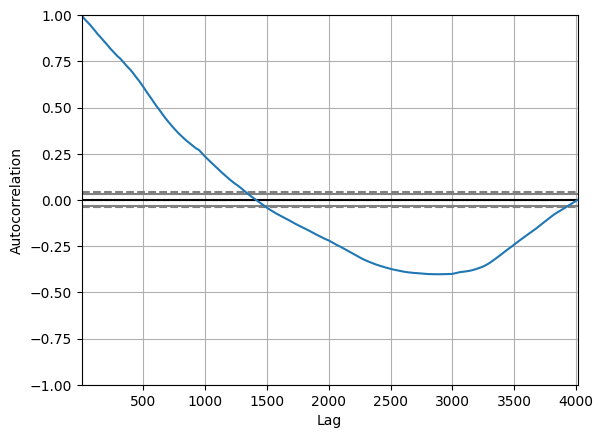

In [139]:
autocorrelation_plot(dataset)

In [140]:
#Create ARIMA model to find best order params for this dataset
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings

p_values = range(0,3)
d_values = range(0,1)
q_values = range(0,3)

best_r2 = float('-inf')
best_params = None

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  for p, d, q in product(p_values, d_values, q_values):
      order = (p, d, q)
      ARIMAmodel = ARIMA(train_data, order=order)
      ARIMAfit = ARIMAmodel.fit()
      ARIMApred = ARIMAfit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

      r2 = r2_score(test_data,ARIMApred)

      if r2 > best_r2:
          best_r2 = r2
          best_params = order

print(f'Best R-squared: {best_r2} with order: {best_params}')

Best R-squared: -0.05962226799287129 with order: (1, 0, 2)


In [141]:
best_model = ARIMA(train_data,order=best_params)
ARIMA_fit = best_model.fit()
ARIMA_pred = pd.DataFrame(ARIMA_fit.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,typ='levels'))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [142]:
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(test_data, ARIMA_pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.07 RMSE


In [143]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data,ARIMA_pred)
print(f'Mean Absolute Error (Test): {mae:.4f}')

# R-squared (Coefficient of Determination)
r2 = r2_score(test_data, ARIMA_pred)
print(f'R-squared (Test): {r2:.4f}')

Mean Absolute Error (Test): 0.0567
R-squared (Test): -0.0596


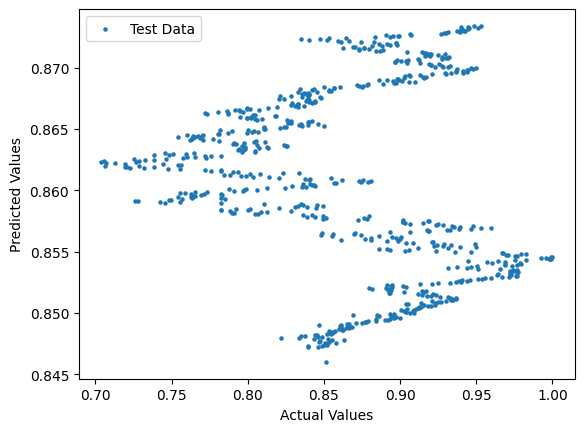

In [144]:
plt.scatter(test_data,ARIMA_pred,label='Test Data',s=5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

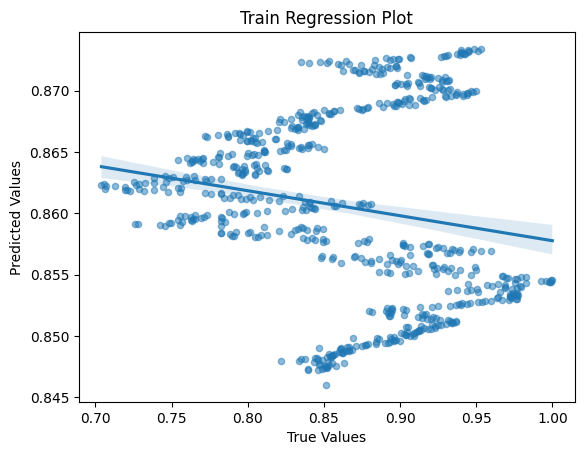

In [145]:
sns.regplot(x=test_data, y=ARIMA_pred, scatter_kws={'s': 20, 'alpha': 0.5})
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Train Regression Plot')
plt.show()